In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 2"

In [3]:
# install dependencies: 
#!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import json, random
#from google.colab.patches import cv2_imshow
import cv2
from IPython.display import display
from IPython.display import Image as IPyImage
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import Visualizer as Vis
from Visualizer import *
from detectron2.data import MetadataCatalog, DatasetCatalog
import importlib
from io import BytesIO
from PIL import Image as PILImage
from matplotlib.pyplot import imshow
import detectron2
import matplotlib.pyplot as plt
from detectron2 import engine
DefaultPredictor = engine.DefaultPredictor
import threading
import multiprocessing
from pprint import pprint
from detectron2.modeling import build_model
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
from mydataset import MyDataset
from torch.utils.data import DataLoader
import pickle

<class 'numpy.ndarray'>
(1196, 800, 3)


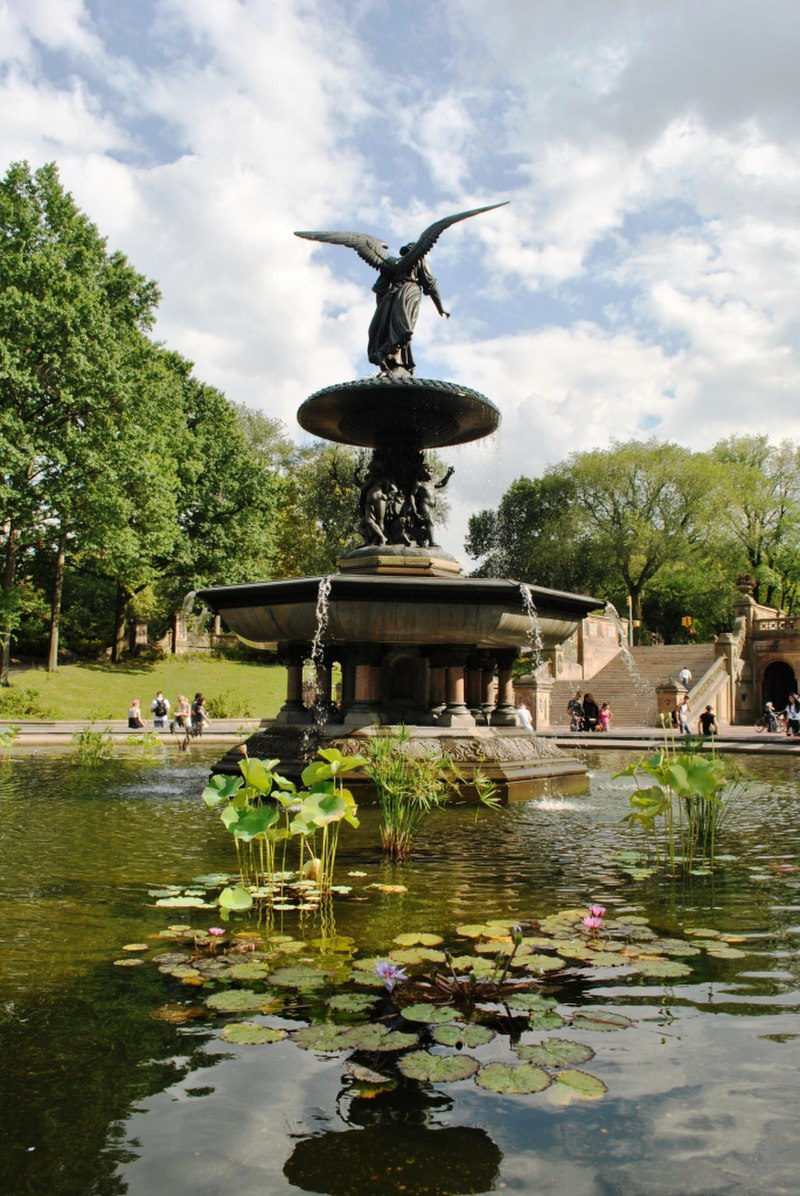

In [44]:
im = PILImage.open("/data/yingshac/MMMHQA/gold_test/00000000.jpg")
nd = np.array(im)
print(type(nd))
print(nd.shape)

im

In [25]:
len(MetadataCatalog.get("coco_2017_train").thing_classes)

80

In [18]:
threshold = 0.5
cfg = get_cfg()
config = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config)
#cfg.MODEL.WEIGHTS = "https://onedrive.live.com/download?cid=E5364FD183A1F5BB&resid=E5364FD183A1F5BB%212014&authkey=AAHgqN3Y-LXcBvU"
cfg.MODEL.WEIGHTS = "/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/e2e_faster_rcnn_X-101-64x4d-FPN_2x-vlp-427.pkl"
#model = build_model(cfg)
#DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS) 
#model = torch.nn.DataParallel(model, device_ids=[0,1]).module

In [36]:
#im_name = random.choice(os.listdir("/data/yingshac/MMMHQA/distractors/"))
im_name = "10117355.jpg" #10308796
#im = PILImage.open(os.path.join("/data/yingshac/MMMHQA/distractors/", im_name)).convert("RGB")
#original_image = np.array(im)

original_image = utils.read_image(os.path.join("/data/yingshac/MMMHQA/distractors/", im_name), format="RGB")
model.eval()
with torch.no_grad():
    #original_image = original_image[:, :, ::-1]
    height, width = original_image.shape[:2]
    aug = T.ResizeShortestEdge([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST)
    image = aug.get_transform(original_image).apply_image(original_image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

    inputs = {"image": image, "height": height, "width": width}
    outputs = model.inference_FE([inputs, inputs])
    

In [38]:
print(type(outputs[0]))

<class 'detectron2.structures.instances.Instances'>


In [6]:
folder = "/data/yingshac/MMMHQA/gold_test/"
abs_paths = [os.path.join(folder, im_name) for im_name in os.listdir(folder)]
dataset = MyDataset(abs_paths, cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MAX_SIZE_TEST)


In [18]:
dataloader = DataLoader(dataset, batch_size=4, num_workers=4, shuffle=False, collate_fn = lambda x: x)
model.eval()
outputs_list = []
im_names_list = []
append = False
with torch.no_grad():
    for batch_idx, item in enumerate(dataloader):
        print(batch_idx)
        inputs = [i[0] for i in item]
        im_names = [i[1] for i in item]
        print(im_names)
        im_names_list.extend(im_names)
        outputs = model.inference_FE(inputs)
        outputs_list.extend(outputs)
        save_RF(im_names_list, outputs_list, "region_features.pkl", append)
        append = True
        outputs_list = []
        im_names_list = []
        if batch_idx>1: break

0
['/data/yingshac/MMMHQA/gold_test/00018049.jpg', '/data/yingshac/MMMHQA/gold_test/00012443.jpg', '/data/yingshac/MMMHQA/gold_test/00006724.jpg', '/data/yingshac/MMMHQA/gold_test/00015766.jpg']
return box_head forward
layer:  Flatten(start_dim=1, end_dim=-1)
layer:  Linear(in_features=25088, out_features=2048, bias=True)
get mid
layer:  ReLU()
layer:  Linear(in_features=2048, out_features=2048, bias=True)
layer:  ReLU()
return box_head partial forward
layer:  Flatten(start_dim=1, end_dim=-1)
layer:  Linear(in_features=25088, out_features=2048, bias=True)
get mid
layer:  ReLU()
layer:  Linear(in_features=2048, out_features=2048, bias=True)
layer:  ReLU()
return box_head partial forward
layer:  Flatten(start_dim=1, end_dim=-1)
layer:  Linear(in_features=25088, out_features=2048, bias=True)
get mid
layer:  ReLU()
layer:  Linear(in_features=2048, out_features=2048, bias=True)
layer:  ReLU()
return box_head partial forward
layer:  Flatten(start_dim=1, end_dim=-1)
layer:  Linear(in_features

In [8]:
def save_RF(im_names_list, outputs_list, filename, append):
    op = 'ab+' if append else 'wb+'
    region_features = {}
    for im_name, output in zip(im_names_list, outputs_list):
        inst = output['instances']
        region_features[os.path.basename(im_name).replace(".jpg", "")] = {"image_size": inst.image_size, "num_instances": len(inst),\
                                                                         "pred_boxes": inst.pred_boxes, "scores": inst.scores, \
                                                                         "pred_classes": inst.pred_classes, \
                                                                          "fc1_features": inst.fc1_features, \
                                                                         "cls_features": inst.cls_features}
    with open("region_features.pkl", op) as fp:
        pickle.dump(region_features,fp)
    


In [74]:
save_RF(im_names_list, outputs_list, "region_features.pkl", True)

In [55]:
with open("region_features.pkl", 'ab') as fp:
    pickle.dump(region_features,fp)
    pickle.dump(region_features,fp)

In [29]:
region_features_reload = {}
count = 0
with open("./Output/region_features_gold.pkl", 'rb') as fr:
    try:
        while count<1:
            count += 1
            region_features_reload.update(pickle.load(fr))
    except EOFError:
        pass
print(len(region_features_reload))

480


In [116]:
print(len(os.listdir("/data/yingshac/MMMHQA/imgFeatures/distractors/")))
#sorted(os.listdir("/data/yingshac/MMMHQA/imgFeatures/distractors/"))[97000:]

315994


In [56]:
k='00012443'
with open("/data/yingshac/MMMHQA/imgFeatures/gold/{}.pkl".format(k), 'rb') as fr:
    region_features_reload = pickle.load(fr)

In [57]:
#k = '00020214'
image_size = region_features_reload.pop('image_size')
region_features_reload.pop('num_instances')
inst = detectron2.structures.instances.Instances(image_size, **region_features_reload)

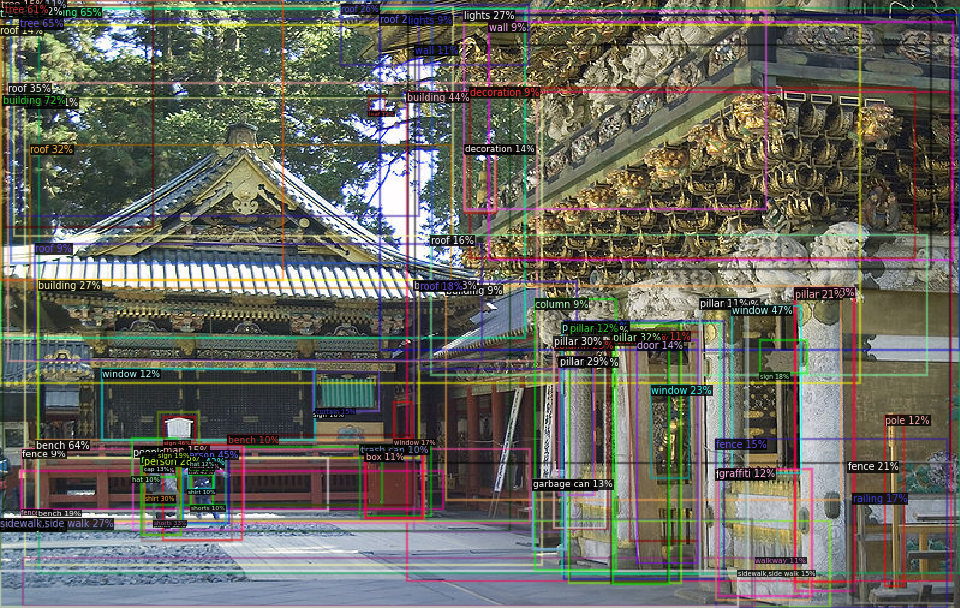

In [58]:
im_name = "/data/yingshac/MMMHQA/gold_test/" + k + ".jpg"
original_image = utils.read_image(im_name, format="RGB")
v = Visualizer(original_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(inst.to("cpu"))
pil_im = PILImage.fromarray(out.get_image()[:, :, ::-1])
pil_im

In [27]:
import time
start = time.time()
time.sleep(5)
print(f'Time: {time.time() - start}')

Time: 5.002751588821411


In [5]:
predictor = DefaultPredictor(cfg)

[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Remove prediction weight for background class in bbox_pred.bias. The shape changes from (6404,) to (6400,).
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Remove prediction weight for background class in bbox_pred.weight. The shape changes from (6404, 2048) to (6400, 2048).
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Move classification weights for background class in cls_score.bias from index 0 to index 1600.
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Move classification weights for background class in cls_score.weight from index 0 to index 1600.
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                 | Shapes                          |
|:------------------------------------------------|:------------------------------------|:---

In [22]:
# We can use `Visualizer` to draw the predictions on the image.
im_name = random.choice(os.listdir("/data/yingshac/MMMHQA/distractors/"))
print(im_name)
im = PILImage.open(os.path.join("/data/yingshac/MMMHQA/distractors/", im_name)).convert("RGB")
im = np.array(im)

ef_outputs = predictor.inference(im)

10134058.jpg
hello


Instances(num_instances=100, image_height=1067, image_width=800, fields=[pred_boxes: Boxes(tensor([[ 451.8947,  728.7969,  482.4771,  910.6707],
        [ 454.1754,  371.4949,  489.4788,  500.6568],
        [ 566.8135,  665.7432,  604.5895,  769.5076],
        [  70.9277,  426.3427,  696.5880, 1067.0000],
        [ 535.4929,  385.7829,  551.1570,  464.6565],
        [  36.3332,  500.2968,  482.7809,  679.9420],
        [  13.6009,   14.5578,  800.0000,  656.3097],
        [ 167.7500,  966.6831,  278.2584, 1064.8619],
        [ 576.7227,  919.8541,  629.5882, 1057.6445],
        [ 512.5895,  383.8223,  527.4733,  465.7465],
        [ 527.9561,  382.1906,  558.1184,  469.5246],
        [ 366.4626,   87.0349,  696.1427, 1052.1675],
        [ 336.1964,  979.4732,  506.6941, 1063.7114],
        [ 440.6402,  727.8301,  498.7801,  919.8019],
        [ 670.5743,  601.8910,  792.3509, 1051.7251],
        [ 108.4827,   88.2051,  726.8040, 1067.0000],
        [ 276.1369,  700.8663,  349.4709, 104

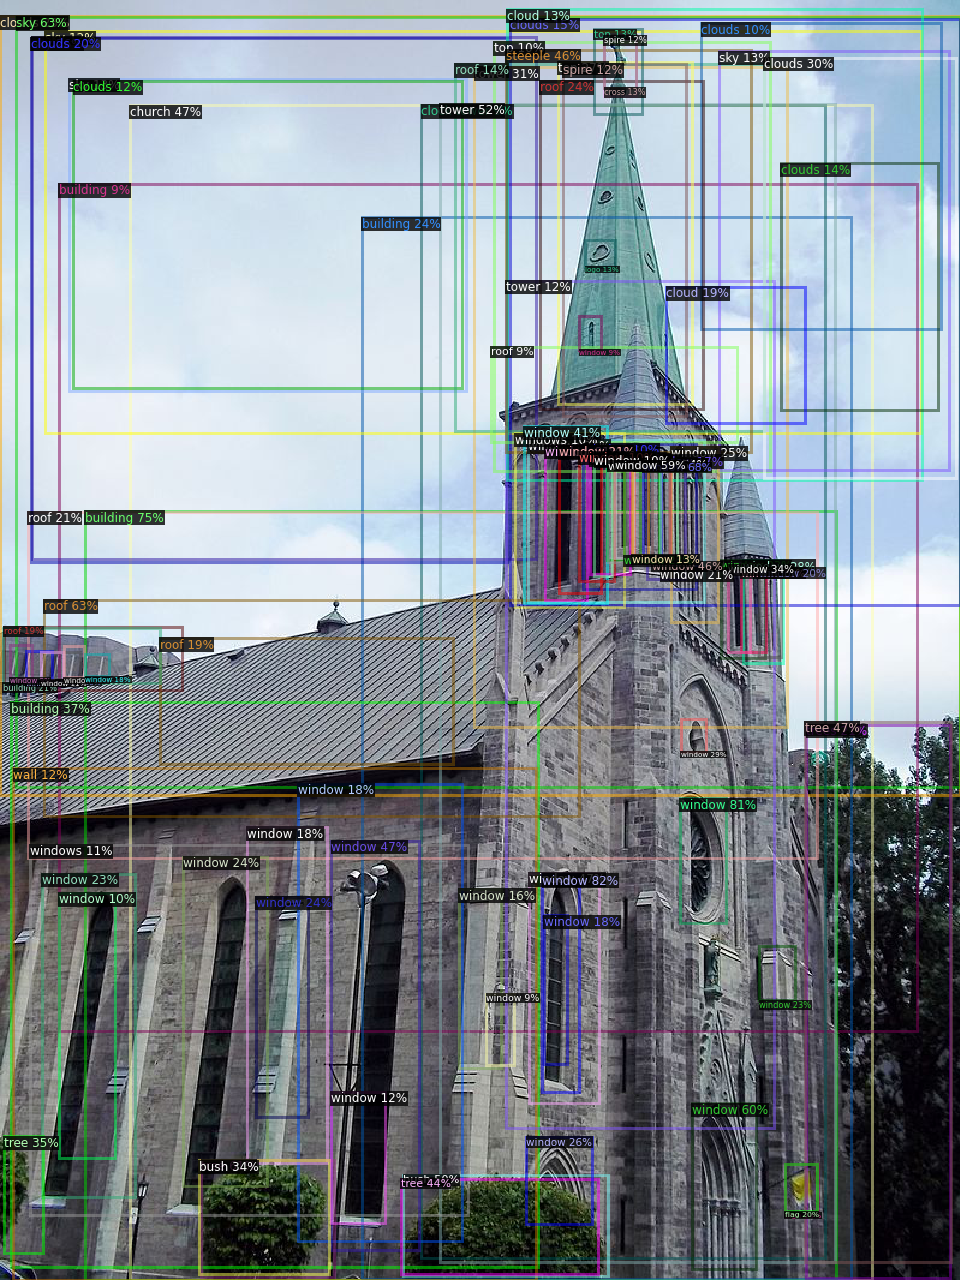

In [28]:
# We can use `Visualizer` to draw the predictions on the image.
#im_name = random.choice(os.listdir("/data/yingshac/MMMHQA/distractors/"))
im_name = random.choice(list(region_features.keys())) + 'jpg'
#im_name = "10117356.jpg" #10308796
im = PILImage.open(os.path.join("/data/yingshac/MMMHQA/gold_test/", im_name)).convert("RGB")
im = np.array(im)

#outputs = predictor(im)
outputs = region_features[]
print(outputs['instances'])
importlib.reload(Vis)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
pil_im = PILImage.fromarray(out.get_image()[:, :, ::-1])
pil_im

In [45]:
def count_bbox(folder, im_names, result, received_im = None):
    for i in range(len(im_names)):
        if i % 200 == 199: print("{} bucket, threshold={}, sample_size={}, finish {}/{}".format(args.bucket, args.threshold, args.sample_size, i, len(im_names)))
        im_name = im_names[i]
        if received_im is not None: received_im.append(im_name)
        im = PILImage.open(os.path.join(folder, im_name)).convert("RGB")    
        im = np.array(im)
        outputs = predictor(im)
        result.append(len(outputs['instances'].scores))
    print("return")

In [35]:
def get_names_from_gold(gold_folder = None):
    if gold_folder is not None: return os.listdir(gold_folder)
    return os.listdir("/data/yingshac/MMMHQA/gold_test/")

In [41]:
def get_names_distractor(dataset_json_path = None):
    path = "/home/yingshac/CYS/WebQnA/WebQnA_data/dataset-Copy1.json" if dataset_json_path is None else dataset_json_path
    file = open(path, "r")
    dataset_J = json.load(file)
    file.close()
    return list(set([str(g)+'jpg' for k in dataset_J for g in dataset_J[k]['DistractorIds']]))

In [44]:
# We can use `Visualizer` to draw the predictions on the image.
bucket = 1
all_ims = "/data/yingshac/MMMHQA/gold_test/" if bucket==0 else "/data/yingshac/MMMHQA/distractors/"
sample_size = 3200
num_threads = 32
im_names = random.sample(os.listdir(folder), sample_size)
checkpoints = []
for i in range(num_threads):
    checkpoints.append((i*sample_size//num_threads, (i+1)*sample_size//num_threads))
results = dict((i, []) for i in range(num_threads))
received_ims = dict((i, []) for i in range(num_threads))
threads = []
for i in range(num_threads):
    c = checkpoints[i]
    t = threading.Thread(target=count_bbox, args=(im_names[c[0]:c[1]], results[i], received_ims[i]))
    t.start()
    threads.append(t)
    #count_bbox(im_names[c[0]:c[1]], results[i])
for t in threads:
    t.join()

start
start
start
start
start
start
start
startstart
start

startstart
start

start
start
startstart

start
start
start
start
start
start
start
start
start
start
startstart

start
start
start


KeyboardInterrupt: 

In [34]:
#print(results)
print(len(set([i for v in received_ims.values() for i in v])))
print(np.mean([n for v in results.values() for n in v]))

0
nan


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


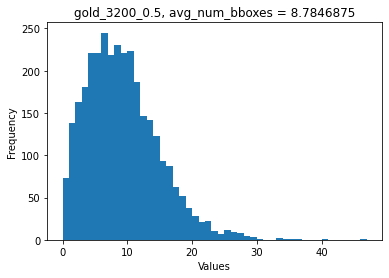

<Figure size 432x288 with 0 Axes>

In [32]:
bucket_name = 'gold' if bucket == 0 else 'distractor'
data = [n for v in results.values() for n in v]
n, bins, patches=plt.hist(data, bins = max(data)-min(data))
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.title('{}_{}_{}, avg_num_bboxes = {}'.format(bucket_name, sample_size, threshold, np.mean(data)))
plt.show()
plt.savefig('{}_{}_{}.jpg'.format(bucket_name, sample_size, threshold))

In [46]:
threshold = 0.5
cfg = get_cfg()
config = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = float(threshold)  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = "/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/e2e_faster_rcnn_X-101-64x4d-FPN_2x-vlp-427.pkl"
predictor = DefaultPredictor(cfg)

# We can use `Visualizer` to draw the predictions on the image.
bucket = 'gold' #args.bucket.lower()

all_ims = "/data/yingshac/MMMHQA/gold_test/" if bucket=='gold' else "/data/yingshac/MMMHQA/distractors/"
sample_size = 4000 #args.sample_size
num_threads = 32 #args.num_threads
im_names = random.sample(os.listdir(all_ims), sample_size)
checkpoints = []
for i in range(num_threads):
    checkpoints.append((i*sample_size//num_threads, (i+1)*sample_size//num_threads))
results = dict((i, []) for i in range(num_threads))
received_ims = dict((i, []) for i in range(num_threads))
threads = []
for i in range(num_threads):
    c = checkpoints[i]
    t = threading.Thread(target=count_bbox, args=(all_ims, im_names[c[0]:c[1]], results[i], received_ims[i]))
    t.start()
    threads.append(t)
    #count_bbox(im_names[c[0]:c[1]], results[i])
for t in threads:
    t.join()

assert len(set([i for v in received_ims.values() for i in v])) == sample_size
#print(received_ims.values())
data = [n for v in results.values() for n in v]
n, bins, patches=plt.hist(data, bins = max(data)-min(data))
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.title('{}_{}_{}, avg_num_bboxes = {}'.format(bucket, sample_size, threshold, np.mean(data)))
plt.show()

plt.savefig('{}_{}_{}.jpg'.format(bucket, sample_size, threshold))

[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Remove prediction weight for background class in bbox_pred.bias. The shape changes from (6404,) to (6400,).
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Remove prediction weight for background class in bbox_pred.weight. The shape changes from (6404, 2048) to (6400, 2048).
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Move classification weights for background class in cls_score.bias from index 0 to index 1600.
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Move classification weights for background class in cls_score.weight from index 0 to index 1600.
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                 | Shapes                          |
|:------------------------------------------------|:------------------------------------|:---

KeyboardInterrupt: 

In [11]:
#print(im_name)
im = cv2.imread(os.path.join(folder, "10029706.jpg"))
print(type(im))
cv2_imshow(im)

<class 'NoneType'>


NameError: name 'cv2_imshow' is not defined

In [168]:
num_instances

[1, 44, 7, 16, 5, 13, 12, 5, 9, 8]

In [166]:
print(outputs['instances'])

Instances(num_instances=12, image_height=1200, image_width=800, fields=[pred_boxes: Boxes(tensor([[  37.1553,    5.8787,  800.0000,  298.7236],
        [ 361.0041,  968.8079,  498.2404, 1171.2029],
        [ 345.7630,  913.6789,  507.1032, 1193.5778],
        [  15.7577,  208.2579,  800.0000, 1200.0000],
        [ 211.5467,  559.5577,  302.0444,  679.6015],
        [ 129.9746,  658.5369,  347.0980,  734.0342],
        [ 529.0677, 1075.6403,  598.0831, 1127.2184],
        [ 206.9528,  823.9233,  302.4140,  990.1008],
        [ 112.6264,  650.2717,  770.4163,  755.3536],
        [ 391.1039,  567.1718,  427.9186,  599.5074],
        [ 412.1770,  970.7963,  453.6086, 1029.9281],
        [ 571.3470,  819.1752,  664.4602,  987.6434]], device='cuda:0')), scores: tensor([0.8738, 0.7880, 0.7728, 0.7551, 0.7309, 0.6989, 0.6981, 0.6392, 0.5811,
        0.5510, 0.5382, 0.5225], device='cuda:0'), pred_classes: tensor([  72,  310,   50,  177,  453, 1507,  128,  453, 1507,  453,   51,  453],
       d

In [50]:
pickle.dump(cpt, open("/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/e2e_faster_rcnn_X-101-64x4d-FPN_2x-vlp-427.pkl", "wb"))

In [37]:
model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'

In [39]:
cpt_d2 = pickle.load(open("/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/faster_rcnn_X_101_32x8d_FPN_3x.pkl", "rb"), encoding='latin1')
print(type(cpt_d2))

<class 'dict'>


In [42]:
print(cpt_d2['model'].keys())

odict_keys(['backbone.fpn_lateral2.weight', 'backbone.fpn_lateral2.bias', 'backbone.fpn_output2.weight', 'backbone.fpn_output2.bias', 'backbone.fpn_lateral3.weight', 'backbone.fpn_lateral3.bias', 'backbone.fpn_output3.weight', 'backbone.fpn_output3.bias', 'backbone.fpn_lateral4.weight', 'backbone.fpn_lateral4.bias', 'backbone.fpn_output4.weight', 'backbone.fpn_output4.bias', 'backbone.fpn_lateral5.weight', 'backbone.fpn_lateral5.bias', 'backbone.fpn_output5.weight', 'backbone.fpn_output5.bias', 'backbone.bottom_up.stem.conv1.weight', 'backbone.bottom_up.stem.conv1.norm.weight', 'backbone.bottom_up.stem.conv1.norm.bias', 'backbone.bottom_up.stem.conv1.norm.running_mean', 'backbone.bottom_up.stem.conv1.norm.running_var', 'backbone.bottom_up.res2.0.shortcut.weight', 'backbone.bottom_up.res2.0.shortcut.norm.weight', 'backbone.bottom_up.res2.0.shortcut.norm.bias', 'backbone.bottom_up.res2.0.shortcut.norm.running_mean', 'backbone.bottom_up.res2.0.shortcut.norm.running_var', 'backbone.bottom_

### Reading VLP Code

In [124]:
# Try loading vqa annotations to see the data structure
import numpy as np
img_dat = np.load("/home/yingshac/CYS/WebQnA/vqa2_annotations/vqa/imdb_minival2014.npy", allow_pickle=True)

In [125]:
print(len(img_dat))

65989


In [126]:
print(img_dat[0])
print(img_dat[1])

{'create_time': '2018-04-18 13:01', 'dataset_name': 'vqa', 'version': 1, 'has_answer': True, 'has_gt_layout': False, 'created_at': <built-in function time>}
{'image_name': 'COCO_val2014_000000262162', 'image_id': 262162, 'question_id': 262162000, 'feature_path': 'COCO_val2014_000000262162.npy', 'question_str': 'Is that a folding chair?', 'question_tokens': ['is', 'that', 'a', 'folding', 'chair'], 'all_answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'], 'ocr_tokens': [], 'answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']}


In [173]:
import torch
x = torch.randn((100, 2048))
print(x.size())
y = x.new((1,2,2))
print(y.size())
print(y)

torch.Size([100, 2048])
torch.Size([3])
tensor([1., 2., 2.])


### Write Dataset class

In [174]:
from transformers import BertTokenizer, BertModel

model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [179]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_a = tokenizer.tokenize("Hi!")
text_b = tokenizer.tokenize("Hello!")
text_c = tokenizer.tokenize("Morning!")
tokenized_text = ["[CLS]"] + text_a + ["[SEP]"] + text_b + ["[SEP]"] + text_c + ["[SEP]"]

# Tokenize our sentence with the BERT tokenizer.
#tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [0] * (2+len(text_a)) + [1] * (1+len(text_b)) + [2] * (1+len(text_c)) 
    
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
        # becase we set `output_hidden_states = True`, the third item will be the hidden states from all layers. 
    hidden_states = outputs[2]

In [188]:
tokenizer.tokenize('"What is your name?"')

['"', 'what', 'is', 'your', 'name', '?', '"']

In [206]:
os.path.exists("/data/yingshac/MMMHQA/imgFeatures/distractors/10000000.pkl")

True

In [271]:
with open("/home/yingshac/CYS/WebQnA/WebQnA_data/dataset_J0501-Copy1.json", "r") as f:
    dataset_J = json.load(f)
print(dataset_J["0"])

{'Q': '"What is floating in the pond around Bethesda Fountain?"', 'A': '"Lilypads"', 'Qtype': 'img-Singlehop', 'GoldIds': ['00000000'], 'DistractorIds': ['10340070', '10340074', '10340071', '10340081', '10340079', '10340076', '10340072', '10000012', '10340077', '10340078', '10042513', '10000000', '10340075', '10000004', '10000003', '10000008', '10000002', '10000001', '10000006', '10340080', '10000019', '10340073'], 'topic': 'Other', 'split': 'train'}


In [331]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [334]:
from collections import Counter
segment_b_len_list = []
for k in dataset_J:
    l = len(tokenizer.tokenize(dataset_J[k]['Q']) + tokenizer.tokenize(dataset_J[k]['A']))
    if l>109:
        print(dataset_J[k])
    segment_b_len_list.append(l)
c = Counter(segment_b_len_list)
for l in c:
    if l>109:
        print("segment_b_len = {}: count = {}".format(l, c[l]))

{'Q': '"Which appears to be more in tact: Decorative wall tile with a knob, geometric and floral patterns, 883-859 BCE. From Assur, Iraq. Pergamon Museum, Berlin, Germany or Decorative wall tile with a knob, geometric and floral patterns, inscription of Ashurnasirpal II, 883-859 BCE. From Assur, Iraq. Pergamon Museum, Berlin, Germany?"', 'A': '"Decorative wall tile with a knob, geometric and floral patterns, inscription of Ashurnasirpal II"', 'Qtype': 'img-Multihop', 'GoldIds': ['00014383', '00014384'], 'DistractorIds': ['10233394', '10233421', '10233403', '10233409', '10233414', '10205664', '10233415', '10160098', '10233405', '10233399', '10233398', '10233407', '10233400', '10233406', '10079308', '10233397', '10045097', '10233408', '10233412', '10233404', '10233392', '10233413', '10233396', '10233393', '00003189', '10233411', '10160093', '10233416', '10233395', '10233402', '10045091', '10233420', '10233410', '10233401', '10160104', '10233391', '10233422', '10205663', '10233419', '1023

In [333]:
tokens = tokenizer.tokenize(datum['Q']) + tokenizer.tokenize(datum['A'])
print(len(tokens))
print(tokens)

112
['"', 'At', 'which', 'location', 'could', 'you', 'easily', 'buy', 'a', 'Big', 'G', '##ulp', 'at', '7', 'in', 'the', 'morning', ';', 'Royal', 'Square', ',', 'Quebec', 'City', ',', 'Quebec', ',', 'Canada', 'or', 'A', '##v', '.', 'Vicente', 'Su', '##árez', 'looking', 'east', 'from', 'A', '##v', '.', 'Mi', '##cho', '##ac', '##án', 'and', 'Call', '##e', 'At', '##lix', '##co', ',', 'co', '##l', '.', 'Hip', '##ó', '##dr', '##omo', 'Con', '##des', '##a', ',', 'Con', '##des', '##a', ',', 'Mexico', 'City', '?', '"', '"', 'A', '##v', '.', 'Vicente', 'Su', '##árez', 'looking', 'east', 'from', 'A', '##v', '.', 'Mi', '##cho', '##ac', '##án', 'and', 'Call', '##e', 'At', '##lix', '##co', ',', 'co', '##l', '.', 'Hip', '##ó', '##dr', '##omo', 'Con', '##des', '##a', ',', 'Con', '##des', '##a', ',', 'Mexico', 'City', '"']


In [313]:
with open("/data/yingshac/MMMHQA/imgFeatures_upd/gold/00000000.pkl", "rb") as f:
    feat = pickle.load(f)
#print(feat)
#print(type(feat['fc1_features']))
#print(type(feat['cls_features']))
#print(feat.keys())

In [318]:
print(feat['fc1_features'].detach().cpu())


tensor([[  4.6652,  -2.7518,   5.6746,  ...,  -5.4363,   1.4304,  10.9959],
        [  9.1867,  -0.7274,   4.2559,  ...,  -5.9934,  -0.1215,   2.9070],
        [  3.3118,  -4.1519,  -2.3694,  ...,  -4.5509,  -2.2792,  -4.2293],
        ...,
        [ -6.0772,  -1.6450,  -4.3508,  ...,  -7.8893,  -1.8848,  -3.0481],
        [ 18.7353,   4.3724,  -5.7358,  ...,   0.5735,   4.6725,  -1.4423],
        [ -2.2864,   2.9457,   4.6604,  ..., -12.8313,   5.4913,  -5.9088]])


In [262]:
x = torch.zeros((4, 5, 2))
x[torch.tensor([0,2]), 1:3, :] = torch.ones((4,5,2))[[0,2], 1:3, :]
print(x)

tensor([[[0., 0.],
         [1., 1.],
         [1., 1.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [1., 1.],
         [1., 1.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])


In [221]:
x = torch.tensor([False, True, False], dtype=torch.long)
print(x)

tensor([0, 1, 0])


In [319]:
prediction = torch.tensor([[1.,0.,0.,0.], [0.,0.,0.,9.]])
logs_prediction = torch.nn.functional.log_softmax(prediction, dim=-1)
print(logs_prediction)
label = torch.tensor([1,3])
CEloss = torch.nn.CrossEntropyLoss(reduction='none')
loss = CEloss(prediction.float(), label)
print(loss)

tensor([[-7.4367e-01, -1.7437e+00, -1.7437e+00, -1.7437e+00],
        [-9.0004e+00, -9.0004e+00, -9.0004e+00, -3.7020e-04]])
tensor([1.7437e+00, 3.7020e-04])


In [267]:
img = torch.randn((15, 100, 2048))
vis_pad = torch.zeros((img.size(0), 400-img.size(1), img.size(2)))
print(vis_pad.size())
img = torch.cat((img, vis_pad), dim=1)
print(img.size())

torch.Size([15, 300, 2048])
torch.Size([15, 400, 2048])


In [274]:
len(os.listdir("/data/yingshac/MMMHQA/gold_test"))

22265

In [322]:
loss = torch.randn((16, 3))
mask = torch.ones((16, 3))
keep_loss, keep_ind = torch.topk(loss.sum(-1), int(16*0.7), largest=False)
print(keep_loss)
print(keep_ind)
print(mask.sum(-1)[keep_ind])

tensor([-1.5732, -1.3974, -1.0162, -0.8577, -0.7355,  0.0619,  0.2124,  0.4583,
         0.7152,  0.8995,  1.2548])
tensor([ 4, 10, 11, 13,  9, 15,  8,  0, 14, 12,  3])
tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])
